In [1]:
#importing necessary libaries for data manipulation and visualization
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
#importing neceassary libaries for prediction
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
#loading the dataset
df = pd.read_csv('Downloads/weather_dataset_2015_2023.xls')
df.head()

,date,temperature,humidity,precipitation,wind_speed,pressure,cloud_cover,solar_radiation,visibility,month,year,day_of_year,day_of_week,is_weekend,apparent_temperature
0,2015-01-01,4.2,78.1,0.53,7.4,1006.0,77.6,175.9,9.4,1,2015,1,3,0,4.323608
1,2015-01-02,3.8,74.8,0.02,7.1,1013.5,70.0,256.6,9.4,1,2015,2,4,0,3.777506
2,2015-01-03,6.1,77.5,0.57,7.0,1013.0,86.0,268.6,9.4,1,2015,3,5,1,6.505259
3,2015-01-04,7.5,91.1,0.24,10.8,1016.3,57.9,194.5,11.0,1,2015,4,6,1,8.612653
4,2015-01-05,1.8,59.9,0.07,8.2,1012.8,69.1,209.6,9.0,1,2015,5,0,0,1.174029


In [7]:
# Handling missing values - forward fill for weather data
numeric_cols = ['temperature', 'humidity', 'precipitation', 'wind_speed', 
                'pressure', 'cloud_cover', 'solar_radiation', 'visibility', 
                'apparent_temperature']

for col in numeric_cols:
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

# Checking for any remaining missing values
print(f"\nRemaining missing values after imputation:\n{df.isnull().sum()}")


Remaining missing values after imputation:
date                    0
temperature             0
humidity                0
precipitation           0
wind_speed              0
pressure                0
cloud_cover             0
solar_radiation         0
visibility              0
month                   0
year                    0
day_of_year             0
day_of_week             0
is_weekend              0
apparent_temperature    0
dtype: int64


In [3]:
# Checking if 'date' column exists and its current type
print(f"\n'date' column type: {type(df['date'].iloc[0]) if 'date' in df.columns else 'Column not found'}")
print(f"'date' column sample: {df['date'].iloc[0] if 'date' in df.columns else 'N/A'}")


'date' column type: <class 'str'>
'date' column sample: 2015-01-01


In [4]:
# Converting date to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print(f"\nAfter conversion, 'date' dtype: {df['date'].dtype}")
    
    # Check for any conversion errors
    null_dates = df['date'].isnull().sum()
    if null_dates > 0:
        print(f"Warning: {null_dates} dates couldn't be converted")
        print("Sample problematic dates:")
        print(df[df['date'].isnull()][['date']].head())
else:
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    print(f"\nPotential date columns found: {date_cols}")
    if date_cols:
        df['date'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
        print(f"Using column '{date_cols[0]}' as date")
    else:
        # If no date column found, creating one from year, month columns
        if 'year' in df.columns and 'month' in df.columns and 'day_of_year' in df.columns:
            print("Creating date from year, month, and day_of_year columns")
            # Creating a date column (approximate since day_of_year is not exact day)
            df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + 
                                        df['month'].astype(str) + '-01')
        else:
            # Create a simple index-based date
            print("Creating synthetic date column")
            start_date = pd.to_datetime('2015-01-01')
            df['date'] = [start_date + pd.Timedelta(days=i) for i in range(len(df))]



After conversion, 'date' dtype: datetime64[ns]


In [5]:
# Creating time-based features
if 'day_of_year' not in df.columns:
    df['day_of_year'] = df['date'].dt.dayofyear
    print("Created 'day_of_year' column")

df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear/365)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear/365)

In [6]:
print(f"\nSuccessfully created time features:")
print(f"month_sin: {df['month_sin'][:3].tolist()}")
print(f"month_cos: {df['month_cos'][:3].tolist()}")
print(f"day_sin: {df['day_sin'][:3].tolist()}")
print(f"day_cos: {df['day_cos'][:3].tolist()}")


Successfully created time features:
month_sin: [0.49999999999999994, 0.49999999999999994, 0.49999999999999994]
month_cos: [0.8660254037844387, 0.8660254037844387, 0.8660254037844387]
day_sin: [0.017213356155834685, 0.03442161162274574, 0.051619667223253764]
day_cos: [0.9998518392091162, 0.9994074007397048, 0.998666816288476]


In [7]:
# Lag features for temperature prediction
for lag in [1, 2, 3, 7, 14, 30]:  # 1, 2, 3 days, 1 week, 2 weeks, 1 month
    df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)
    df[f'apparent_temp_lag_{lag}'] = df['apparent_temperature'].shift(lag)
    df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)

In [8]:
# Rolling statistics
df['temp_rolling_mean_7'] = df['temperature'].rolling(window=7, min_periods=1).mean()
df['temp_rolling_std_7'] = df['temperature'].rolling(window=7, min_periods=1).std()
df['humidity_rolling_mean_7'] = df['humidity'].rolling(window=7, min_periods=1).mean()

# Difference features
df['temp_diff_1'] = df['temperature'].diff(1)
df['pressure_diff_1'] = df['pressure'].diff(1)

# Interaction features
df['temp_humidity_interaction'] = df['temperature'] * df['humidity'] / 100
df['wind_chill'] = 13.12 + 0.6215*df['temperature'] - 11.37*(df['wind_speed']**0.16) + 0.3965*df['temperature']*(df['wind_speed']**0.16)

# Filling NaN values created by lag features
df = df.fillna(method='bfill')
print(f"Dataset shape after feature engineering: {df.shape}")

Dataset shape after feature engineering: (3287, 44)


In [9]:
# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Using temperature as the primary prediction target
target_col = 'temperature'

In [11]:
# Selecting features for prediction
feature_cols = [
    'humidity', 'precipitation', 'wind_speed', 'pressure', 
    'cloud_cover', 'solar_radiation', 'visibility', 'apparent_temperature',
    'month', 'day_of_year', 'day_of_week', 'is_weekend',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_7',
    'apparent_temp_lag_1', 'humidity_lag_1',
    'temp_rolling_mean_7', 'temp_rolling_std_7',
    'humidity_rolling_mean_7', 'temp_diff_1',
    'temp_humidity_interaction', 'wind_chill'
]

In [12]:
# Preparing data
X = df[feature_cols]
y = df[target_col]

In [13]:
# Splitting data chronologically (80% train, 20% test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = df['date'].iloc[:split_idx], df['date'].iloc[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training period: {dates_train.min()} to {dates_train.max()}")
print(f"Test period: {dates_test.min()} to {dates_test.max()}")

Training set size: 2629
Test set size: 658
Training period: 2015-01-01 00:00:00 to 2022-03-13 00:00:00
Test period: 2022-03-14 00:00:00 to 2023-12-31 00:00:00


In [14]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Saving the scaler for future use
joblib.dump(scaler, 'weather_scaler.pkl')

# Scaling target separately for better performance
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


In [15]:
# Initializing models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

# Dictionary to store results
results = {}
predictions_dict = {}

In [16]:
# Training and evaluating each model
print("\nTraining and evaluating models...")
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Training the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Making predictions
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Storing predictions
    predictions_dict[model_name] = y_pred
    
    # Calculating metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Storing results
    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'model': model
    }
    
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    # Saving model
    joblib.dump(model, f'{model_name.replace(" ", "_").lower()}_model.pkl')



Training and evaluating models...

Training Linear Regression...
Linear Regression - MAE: 0.0817, RMSE: 0.1161, R²: 0.9998

Training Ridge Regression...
Ridge Regression - MAE: 0.0842, RMSE: 0.1320, R²: 0.9998

Training Random Forest...
Random Forest - MAE: 0.0834, RMSE: 0.2003, R²: 0.9995

Training Gradient Boosting...
Gradient Boosting - MAE: 0.1071, RMSE: 0.1850, R²: 0.9996

Training XGBoost...
XGBoost - MAE: 0.1134, RMSE: 0.2644, R²: 0.9991

Training SVR...
SVR - MAE: 0.9933, RMSE: 1.6738, R²: 0.9651

Training KNN...
KNN - MAE: 1.3377, RMSE: 1.7081, R²: 0.9636


In [17]:
# Creating comparison DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df[['MAE', 'RMSE', 'R²']]
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results_df.round(4))

# Finding best traditional model
best_model_name = results_df['RMSE'].idxmin()
best_model = results[best_model_name]['model']
print(f"\nBest traditional model: {best_model_name} (RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f})")


MODEL PERFORMANCE COMPARISON
                        MAE      RMSE        R²
Linear Regression  0.081673  0.116114  0.999832
Ridge Regression   0.084238  0.131957  0.999783
Random Forest      0.083365  0.200304    0.9995
Gradient Boosting  0.107109  0.184952  0.999574
XGBoost             0.11339   0.26439  0.999129
SVR                0.993317  1.673775  0.965084
KNN                 1.33766  1.708095  0.963637

Best traditional model: Linear Regression (RMSE: 0.1161)


In [18]:
# Building TensorFlow neural network
def build_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    return model

In [19]:
# Creating and compile model
tf_model = build_model((X_train_scaled.shape[1],))
tf_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)
# Early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
# Learning rate scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

print("Model architecture:")
tf_model.summary()

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,489 (60.50 KB)

 Trainable params: 15,041 (58.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
# Train the model
print("\nTraining TensorFlow model...")
history = tf_model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Training TensorFlow model...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 0.4980 - mae: 0.5405 - mse: 0.4980 - val_loss: 0.3252 - val_mae: 0.4781 - val_mse: 0.3252 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2291 - mae: 0.3801 - mse: 0.2291 - val_loss: 0.1661 - val_mae: 0.3260 - val_mse: 0.1661 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1845 - mae: 0.3367 - mse: 0.1845 - val_loss: 0.0923 - val_mae: 0.2368 - val_mse: 0.0923 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1470 - mae: 0.3012 - mse: 0.1470 - val_loss: 0.0489 - val_mae: 0.1717 - val_mse: 0.0489 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1308 - mae: 0.2840 - mse: 0.1308 - val_loss: 0.0369 - val_mae: 0.1442 - val_mse: 0.0369 - learning_rate: 0.0010
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1127 - mae: 0.2664 - mse: 0.1127 - val_los

In [21]:
# Make predictions with TensorFlow model
y_pred_tf_scaled = tf_model.predict(X_test_scaled).flatten()
y_pred_tf = y_scaler.inverse_transform(y_pred_tf_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for TensorFlow model
tf_mae = mean_absolute_error(y_test, y_pred_tf)
tf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tf))
tf_r2 = r2_score(y_test, y_pred_tf)

print(f"\nTensorFlow Model Performance:")
print(f"MAE: {tf_mae:.4f}")
print(f"RMSE: {tf_rmse:.4f}")
print(f"R²: {tf_r2:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

TensorFlow Model Performance:
MAE: 0.3905
RMSE: 0.5259
R²: 0.9966


In [22]:
predictions_dict['TensorFlow NN'] = y_pred_tf

# Adding TensorFlow results to comparison
tf_results_row = pd.DataFrame({
    'MAE': [tf_mae],
    'RMSE': [tf_rmse],
    'R²': [tf_r2]
}, index=['TensorFlow NN'])

results_df = pd.concat([results_df, tf_results_row])
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE COMPARISON (All Models)")
print("="*60)
print(results_df.round(4).sort_values('RMSE'))

# Saving TensorFlow model
tf_model.save('weather_tf_model.keras')
print("\nTensorFlow model saved as 'weather_tf_model'")


FINAL MODEL PERFORMANCE COMPARISON (All Models)
                        MAE      RMSE        R²
Linear Regression  0.081673  0.116114  0.999832
Ridge Regression   0.084238  0.131957  0.999783
Gradient Boosting  0.107109  0.184952  0.999574
Random Forest      0.083365  0.200304    0.9995
XGBoost             0.11339   0.26439  0.999129
TensorFlow NN      0.390486  0.525912  0.996553
SVR                0.993317  1.673775  0.965084
KNN                 1.33766  1.708095  0.963637

TensorFlow model saved as 'weather_tf_model'



Classification Performance Analysis:
--------------------------------------------------------------------------------

Linear Regression:
----------------------------------------
Accuracy: 0.9833
Classification Report:
              precision    recall  f1-score   support

    Freezing       0.97      0.99      0.98        67
        Cold       0.98      0.97      0.98       113
        Cool       0.93      1.00      0.97        14
        Mild       1.00      0.98      0.99       133
        Warm       0.97      0.98      0.97        91
         Hot       0.99      0.99      0.99       240

    accuracy                           0.98       658
   macro avg       0.97      0.98      0.98       658
weighted avg       0.98      0.98      0.98       658



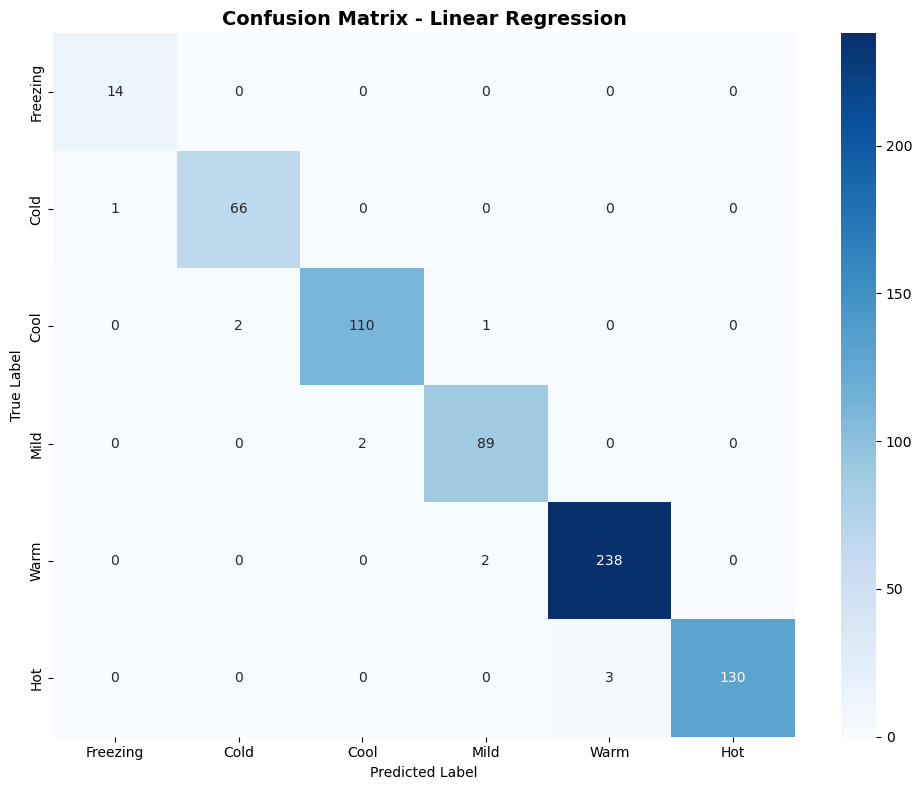


Ridge Regression:
----------------------------------------
Accuracy: 0.9818
Classification Report:
              precision    recall  f1-score   support

    Freezing       0.96      0.97      0.96        67
        Cold       0.97      0.96      0.97       113
        Cool       0.93      1.00      0.97        14
        Mild       1.00      0.98      0.99       133
        Warm       0.97      0.98      0.97        91
         Hot       0.99      0.99      0.99       240

    accuracy                           0.98       658
   macro avg       0.97      0.98      0.98       658
weighted avg       0.98      0.98      0.98       658



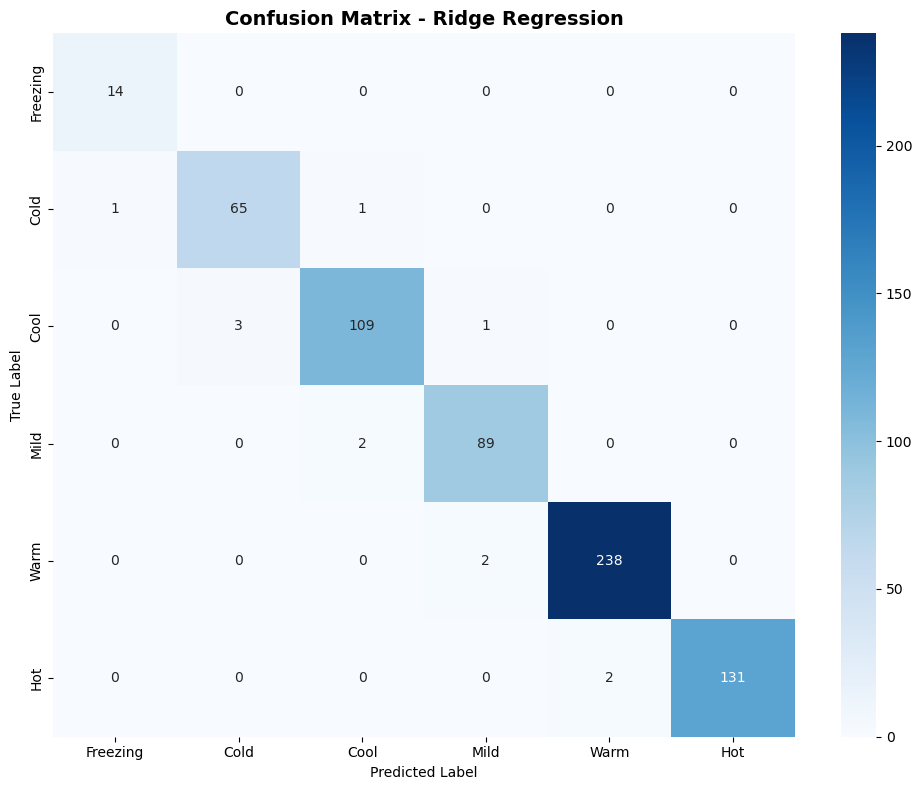


Random Forest:
----------------------------------------
Accuracy: 0.9848
Classification Report:
              precision    recall  f1-score   support

    Freezing       0.97      0.99      0.98        67
        Cold       0.97      0.97      0.97       113
        Cool       1.00      1.00      1.00        14
        Mild       0.99      0.99      0.99       133
        Warm       0.97      0.98      0.97        91
         Hot       1.00      0.99      0.99       240

    accuracy                           0.98       658
   macro avg       0.98      0.99      0.98       658
weighted avg       0.98      0.98      0.98       658



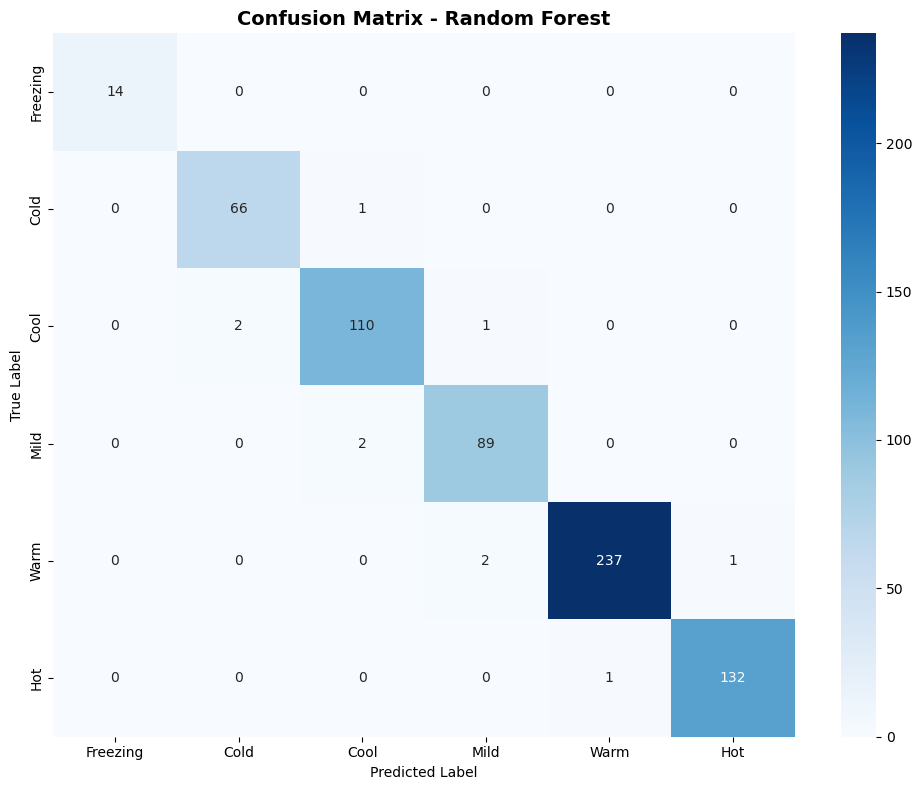


Gradient Boosting:
----------------------------------------
Accuracy: 0.9818
Classification Report:
              precision    recall  f1-score   support

    Freezing       0.94      1.00      0.97        67
        Cold       0.99      0.95      0.97       113
        Cool       1.00      1.00      1.00        14
        Mild       0.99      0.99      0.99       133
        Warm       0.96      0.99      0.97        91
         Hot       1.00      0.98      0.99       240

    accuracy                           0.98       658
   macro avg       0.98      0.99      0.98       658
weighted avg       0.98      0.98      0.98       658


XGBoost:
----------------------------------------
Accuracy: 0.9802
Classification Report:
              precision    recall  f1-score   support

    Freezing       0.93      1.00      0.96        67
        Cold       0.97      0.95      0.96       113
        Cool       1.00      1.00      1.00        14
        Mild       0.99      1.00      0.99     

In [23]:
# Defining temperature categories
def categorize_temperature(temp):
    """Categorize temperature into weather types"""
    if temp < 0:
        return 'Freezing'
    elif temp < 5:
        return 'Cold'
    elif temp < 10:
        return 'Cool'
    elif temp < 15:
        return 'Mild'
    elif temp < 25:
        return 'Warm'
    else:
        return 'Hot'

# Applying categorization to actual and predicted temperatures
y_test_cat = y_test.apply(categorize_temperature)

# Creating a dictionary to store categorical predictions
cat_predictions = {}

# Getting the temperature categories in order for consistent plotting
categories = ['Freezing', 'Cold', 'Cool', 'Mild', 'Warm', 'Hot']

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, categories):
    """Plot confusion matrix for a model"""
    cm = confusion_matrix(y_true, y_pred, labels=categories)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

# Evaluating classification performance for each model
classification_results = {}

print("\nClassification Performance Analysis:")
print("-" * 80)

for model_name, predictions in predictions_dict.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    
    # Converting predictions to categories
    pred_cat = pd.Series(predictions).apply(categorize_temperature)
    cat_predictions[model_name] = pred_cat
    
    # Calculating classification metrics
    accuracy = accuracy_score(y_test_cat, pred_cat)
    
    # Getting classification report
    report = classification_report(y_test_cat, pred_cat, 
                                   target_names=categories, output_dict=True)
    
    # Storing results
    classification_results[model_name] = {
        'accuracy': accuracy,
        'report': report
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_cat, pred_cat, target_names=categories))
    
    # Plotting confusion matrix for top 3 models
    if model_name in results_df.head(3).index:
        cm = plot_confusion_matrix(y_test_cat, pred_cat, model_name, categories)
        classification_results[model_name]['confusion_matrix'] = cm

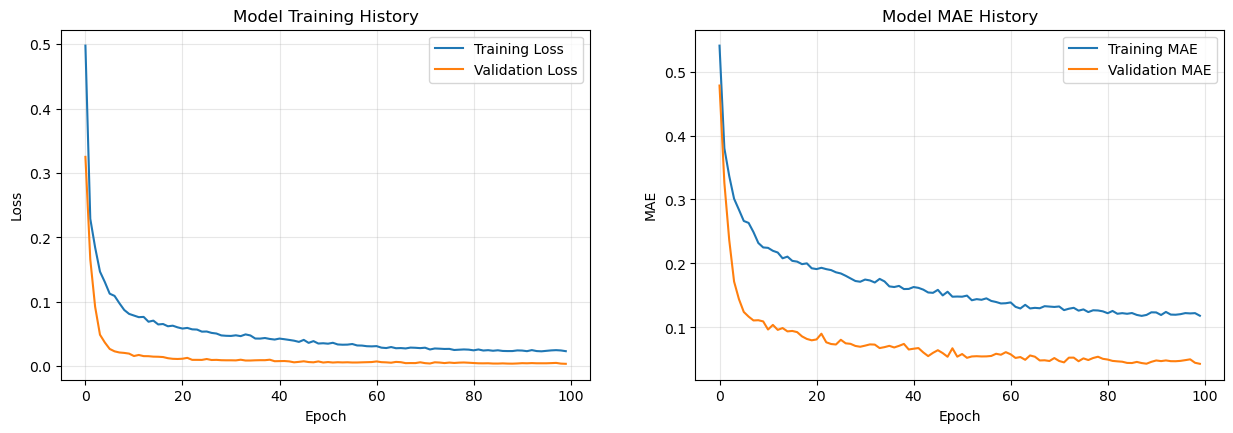

In [24]:
# plotting Training history for TensorFlow model
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# Plotting MAE history
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

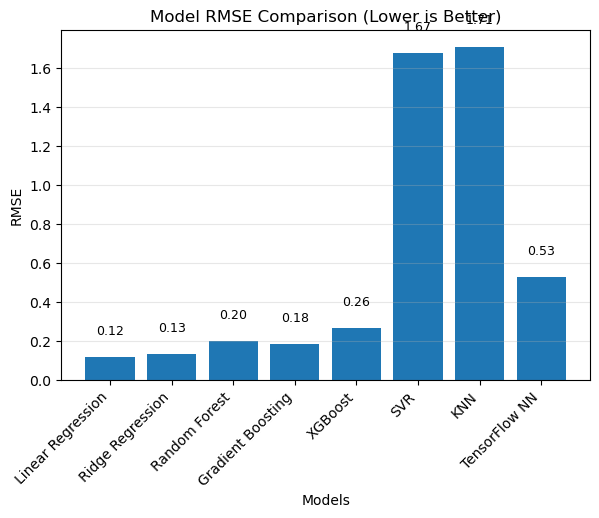

In [25]:
# Model performance comparison
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 3)
models_for_plot = results_df.index.tolist()
rmse_values = results_df['RMSE'].values

bars = plt.bar(models_for_plot, rmse_values)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Adding value labels on bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.show()

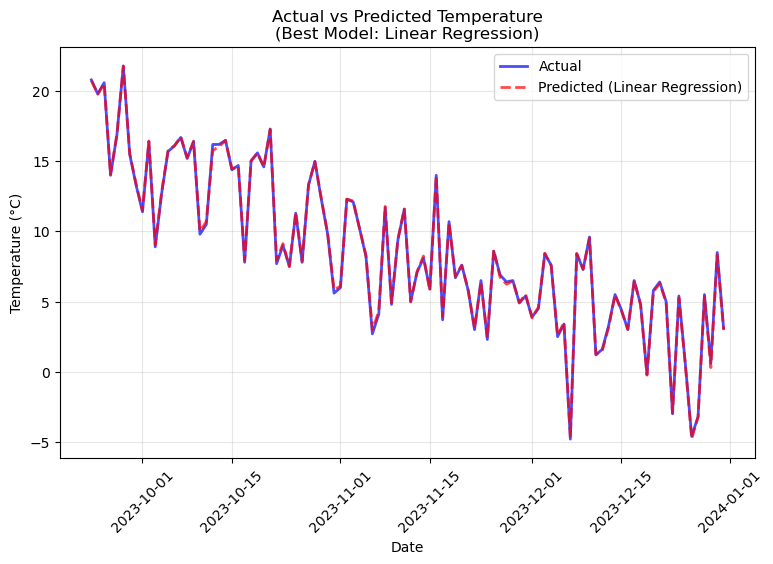

In [26]:
# Actual vs Predicted for best model
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 4)
best_model_name = results_df['RMSE'].idxmin()
best_predictions = predictions_dict[best_model_name]
# Plotting for last 100 days for clarity
plot_range = 100
if len(y_test) > plot_range:
    plot_indices = range(-plot_range, 0)
else:
    plot_indices = range(len(y_test))

plt.plot(dates_test.iloc[plot_indices], y_test.iloc[plot_indices], 
         'b-', label='Actual', alpha=0.7, linewidth=2)
plt.plot(dates_test.iloc[plot_indices], best_predictions[plot_indices], 
         'r--', label=f'Predicted ({best_model_name})', alpha=0.7, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'Actual vs Predicted Temperature\n(Best Model: {best_model_name})')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

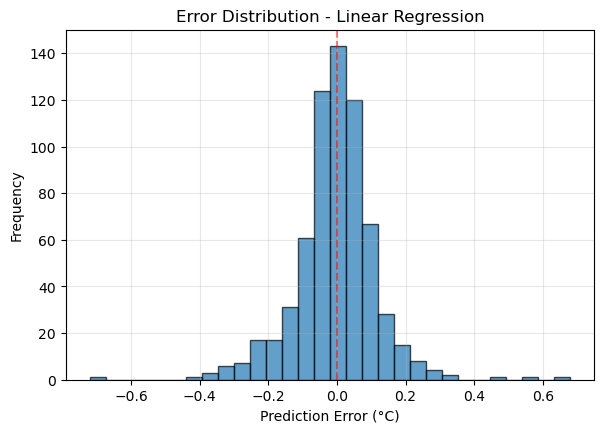

In [27]:
# Predicting error distribution for best model
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
errors = y_test - best_predictions
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (°C)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution - {best_model_name}')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

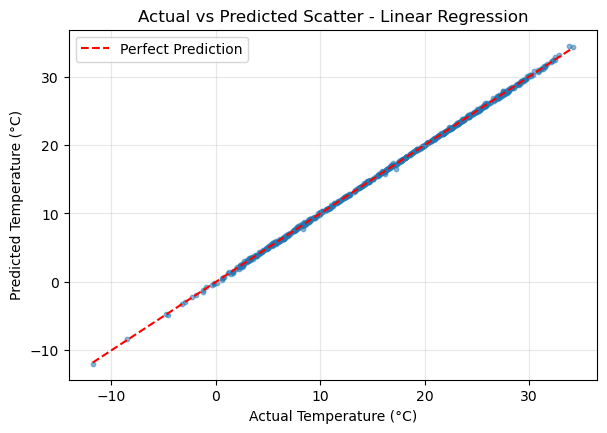

In [28]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 2)
plt.scatter(y_test, best_predictions, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title(f'Actual vs Predicted Scatter - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

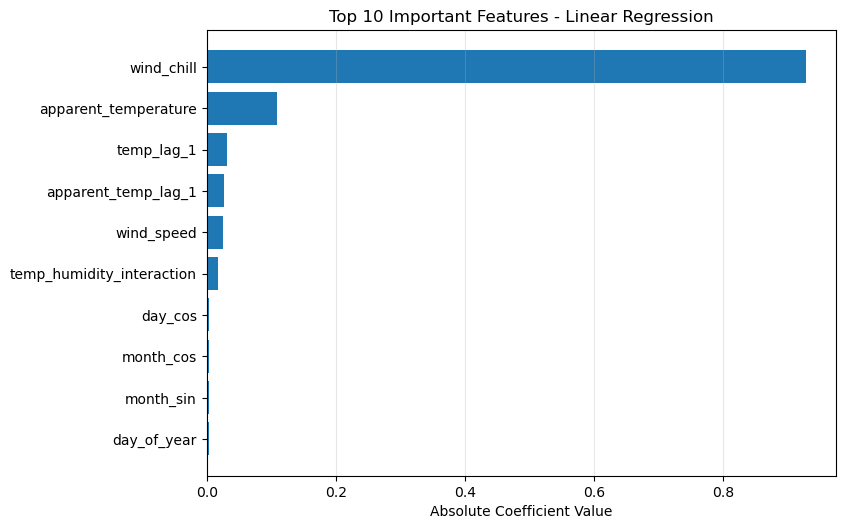

In [29]:
# Feature importance for tree-based models
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 4)
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(range(len(feature_importance)), 
             feature_importance['importance'][::-1])
    plt.yticks(range(len(feature_importance)), 
               feature_importance['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Important Features - {best_model_name}')
else:
    # For linear models
    if hasattr(best_model, 'coef_'):
        coef_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': np.abs(best_model.coef_)
        }).sort_values('importance', ascending=False).head(10)
        
        plt.barh(range(len(coef_importance)), 
                 coef_importance['importance'][::-1])
        plt.yticks(range(len(coef_importance)), 
                   coef_importance['feature'][::-1])
        plt.xlabel('Absolute Coefficient Value')
        plt.title(f'Top 10 Important Features - {best_model_name}')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('detailed_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Function to make future predictions
def predict_future_weather(model_name, last_n_days=30, future_days=7):
    
    # Geting the model
    if model_name == 'TensorFlow NN':
        model = tf_model
    else:
        model = results[model_name]['model']
    
    # Getting recent data
    recent_data = df.tail(last_n_days).copy()
    
    # Preparing for prediction
    predictions = []
    current_features = recent_data[feature_cols].values[-1:]
    
    for day in range(future_days):
        # Scaling features
        current_scaled = scaler.transform(current_features)
        
        # Making prediction
        if model_name == 'TensorFlow NN':
            pred_scaled = model.predict(current_scaled, verbose=0).flatten()[0]
        else:
            pred_scaled = model.predict(current_scaled)[0]
        
        # Inversing transform
        pred = y_scaler.inverse_transform([[pred_scaled]])[0][0]
        predictions.append(pred)
        
        # Updating features for next prediction (simplified approach)
        if day < future_days - 1:
            # Creating new row with predicted temperature
            new_row = recent_data.iloc[-1:].copy()
            new_row['temperature'] = pred
            new_row['date'] = new_row['date'] + pd.Timedelta(days=1)
            
            # Updating lag features (simplified)
            for lag in [1, 2, 3, 7]:
                if lag <= len(recent_data):
                    new_row[f'temp_lag_{lag}'] = recent_data['temperature'].iloc[-lag]
                else:
                    new_row[f'temp_lag_{lag}'] = np.nan
            
            recent_data = pd.concat([recent_data, new_row], ignore_index=True)
            recent_data = recent_data.fillna(method='ffill').fillna(method='bfill')
            current_features = recent_data[feature_cols].values[-1:]
    
    return predictions

In [31]:
# Testing future prediction
print("\n" + "="*60)
print("FUTURE WEATHER PREDICTION DEMO")
print("="*60)

# Getting the best model
best_model_name = results_df['RMSE'].idxmin()
print(f"Using best model: {best_model_name}")

# Predicting next 7 days
future_predictions = predict_future_weather(best_model_name, last_n_days=30, future_days=7)

# Creating future dates
last_date = df['date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

print("\nPredicted temperatures for next 7 days:")
print("-" * 40)
for date, temp in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: {temp:.2f}°C")


FUTURE WEATHER PREDICTION DEMO
Using best model: Linear Regression

Predicted temperatures for next 7 days:
----------------------------------------
2024-01-01: 2.97°C
2024-01-02: 3.14°C
2024-01-03: 3.17°C
2024-01-04: 3.15°C
2024-01-05: 3.13°C
2024-01-06: 3.14°C
2024-01-07: 3.13°C


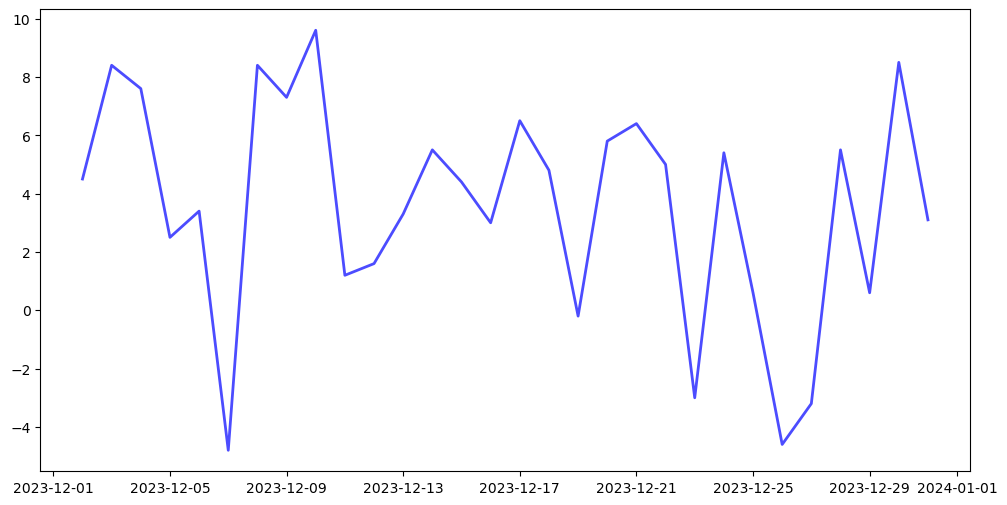

In [32]:
# Visualization of future predictions
# Plotting historical data (last 30 days)
plt.figure(figsize=(12, 6))
historical_dates = df['date'].iloc[-30:]
historical_temps = df['temperature'].iloc[-30:]
plt.plot(historical_dates, historical_temps, 'b-', label='Historical', alpha=0.7, linewidth=2)
plt.show()

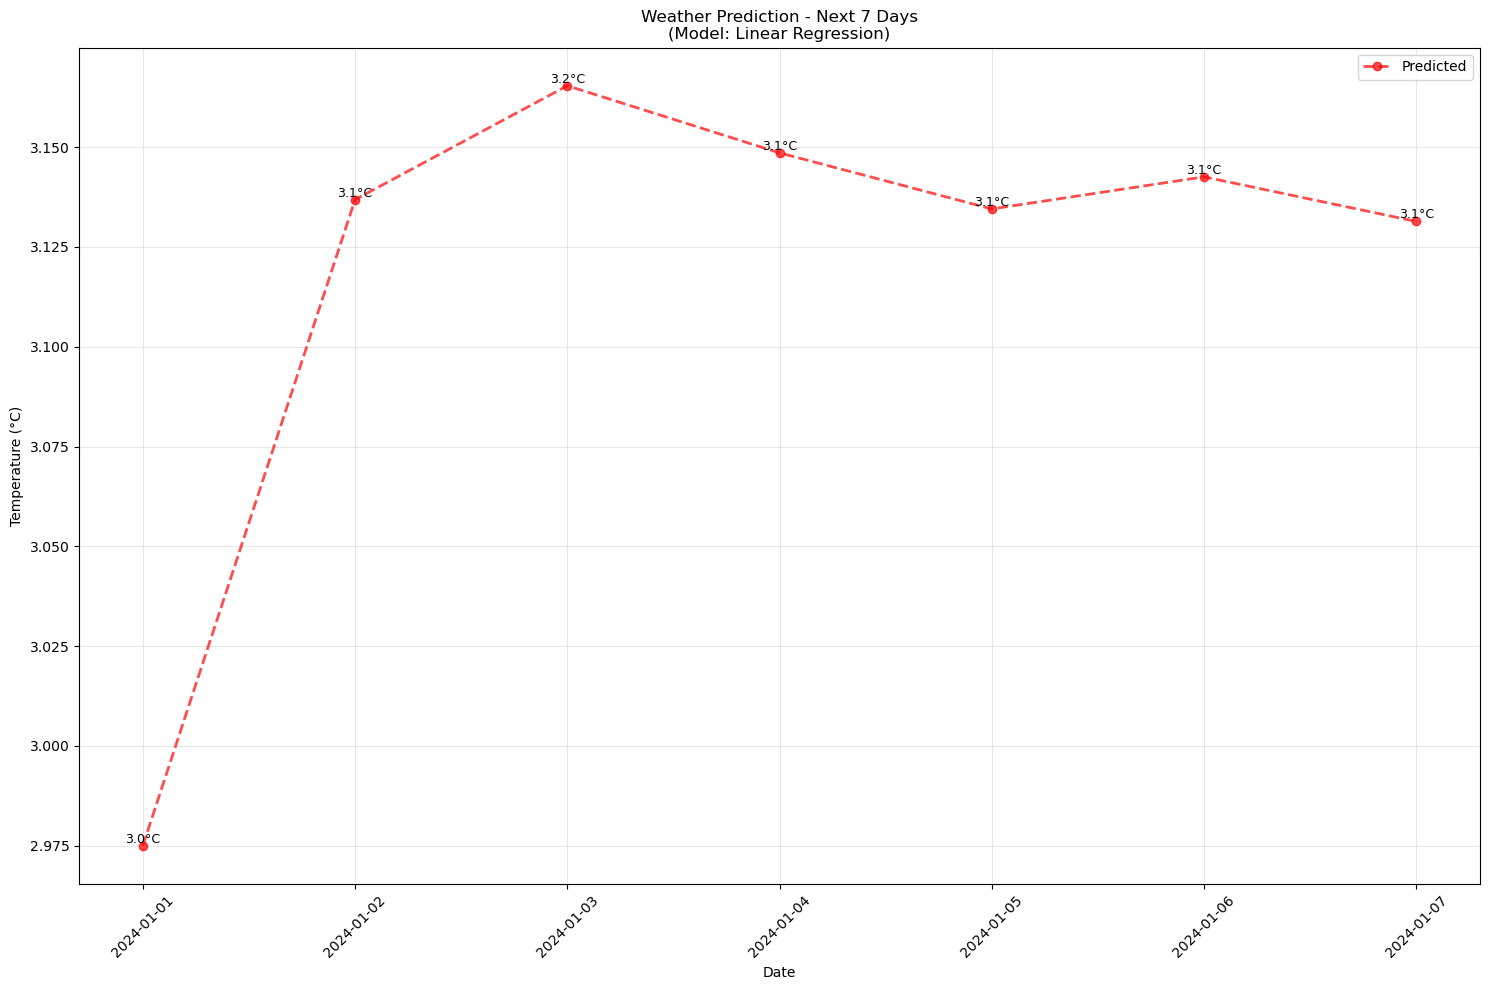

In [33]:
# Plotting future predictions
plt.figure(figsize=(15,10))
plt.plot(future_dates, future_predictions, 'r--o', label='Predicted', alpha=0.7, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'Weather Prediction - Next 7 Days\n(Model: {best_model_name})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Adding value labels for predictions
for date, temp in zip(future_dates, future_predictions):
    plt.text(date, temp, f'{temp:.1f}°C', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('future_predictions.png', dpi=300, bbox_inches='tight')

plt.show()

In [34]:
# Creating a comprehensive report
print("\n" + "="*60)
print("WEATHER PREDICTION SYSTEM SUMMARY")
print("="*60)
print(f"\nDataset Statistics:")
print(f"- Total records: {len(df)}")
print(f"- Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"- Features used: {len(feature_cols)}")
print(f"- Target variable: {target_col}")

print(f"\nBest Performing Model:")
print(f"- Model: {best_model_name}")
print(f"- RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}°C")
print(f"- MAE: {results_df.loc[best_model_name, 'MAE']:.4f}°C")
print(f"- R² Score: {results_df.loc[best_model_name, 'R²']:.4f}")


WEATHER PREDICTION SYSTEM SUMMARY

Dataset Statistics:
- Total records: 3287
- Date range: 2015-01-01 to 2023-12-31
- Features used: 28
- Target variable: temperature

Best Performing Model:
- Model: Linear Regression
- RMSE: 0.1161°C
- MAE: 0.0817°C
- R² Score: 0.9998
